# Forecast California Housing Prices

Import Libraries and housing data

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Set random seed
Set random seed for reproducibility

In [14]:

seed = 50
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


Load Data set

In [15]:
data = fetch_california_housing()
features = pd.DataFrame(data.data, columns=data.feature_names)
targets = pd.Series(data.target, name='Price').values.astype(float).reshape(-1, 1)

**Questions**

* What is a `Bunch`?
* What is the default type for `data`?
* What is the default type for `target`?

**Answers**

1. A `Bunch` is a dictionary-like object in scikit-learn that stores datasets and allows attribute-style access.

2. `data` is a NumPy array by default.

3. `target` is a NumPy array by default.



Data cleaning and preprocessing

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
features_normalized = scaler_X.fit_transform(features)

scaler_y = MinMaxScaler()
targets_normalized = scaler_y.fit_transform(targets)


Create Sequences

In [17]:
def create_sequences(data, targets, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(targets[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 20
X, y = create_sequences(features_normalized, targets_normalized, seq_length)

Train-Test Split and Tensor Conversion

In [18]:
# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, shuffle=False
)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# LSTM model

In [19]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take last time step
        return out

GRU Model

In [20]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

In [21]:
def train_model(model, optimizer, X_train, y_train, num_epochs):
    criterion = nn.MSELoss()
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

In [22]:
# ===== Evaluation Function =====
def evaluate_model(model, X_test, y_test, scaler_y):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).numpy()
    y_true = scaler_y.inverse_transform(y_test.numpy())
    y_pred = scaler_y.inverse_transform(predictions)
    mse = mean_squared_error(y_true, y_pred)
    return y_true, y_pred, mse

Hyperparameters and Model Setup

In [23]:
# ===== Hyperparameters =====
input_size = X_train.shape[2]
output_size = y_train.shape[1]
num_epochs = 50

# Two configurations: one without L2 regularisation, one with it
tuning_configs = {
    "Without Regularisation": [
        {'hidden_size': 64, 'num_layers': 2, 'lr': 0.01, 'weight_decay': 0.0},
        {'hidden_size': 128, 'num_layers': 3, 'lr': 0.005, 'weight_decay': 0.0}
    ],
    "With Regularisation": [
        {'hidden_size': 64, 'num_layers': 2, 'lr': 0.01, 'weight_decay': 0.001},
        {'hidden_size': 128, 'num_layers': 3, 'lr': 0.005, 'weight_decay': 0.001}
    ]
}

results = []



================= Without Regularisation =================

Training LSTM with params: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.01, 'weight_decay': 0.0}
Epoch [10/50], Loss: 0.0964
Epoch [20/50], Loss: 0.0530
Epoch [30/50], Loss: 0.0516
Epoch [40/50], Loss: 0.0486
Epoch [50/50], Loss: 0.0376
LSTM Test MSE: 1.4644

Training GRU with params: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.01, 'weight_decay': 0.0}
Epoch [10/50], Loss: 0.0518
Epoch [20/50], Loss: 0.0318
Epoch [30/50], Loss: 0.0264
Epoch [40/50], Loss: 0.0248
Epoch [50/50], Loss: 0.0239
GRU Test MSE: 0.6323

Training LSTM with params: {'hidden_size': 128, 'num_layers': 3, 'lr': 0.005, 'weight_decay': 0.0}
Epoch [10/50], Loss: 0.1015
Epoch [20/50], Loss: 0.0563
Epoch [30/50], Loss: 0.0535
Epoch [40/50], Loss: 0.0478
Epoch [50/50], Loss: 0.0367
LSTM Test MSE: 1.4859

Training GRU with params: {'hidden_size': 128, 'num_layers': 3, 'lr': 0.005, 'weight_decay': 0.0}
Epoch [10/50], Loss: 0.0566
Epoch [20/50], Loss: 0.0449
Epoch

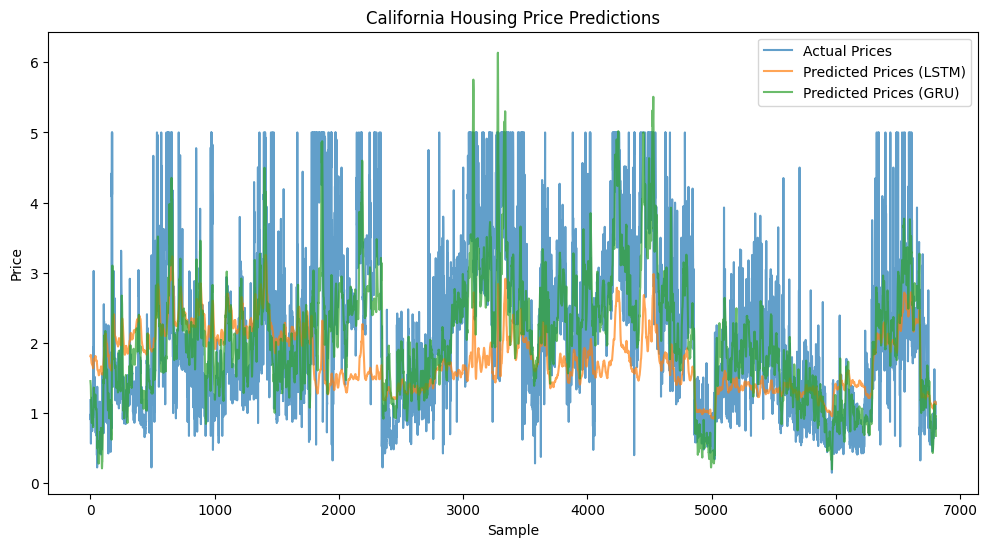

In [24]:
# ===== Hyperparameter Tuning: With and Without Regularisation =====


for config_name, hyperparams_list in tuning_configs.items():
    print(f"\n================= {config_name} =================")
    
    for params in hyperparams_list:
        print(f"\nTraining LSTM with params: {params}")
        lstm_model = LSTMModel(input_size, params['hidden_size'], output_size, params['num_layers'])
        optimizer = optim.Adam(lstm_model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        train_model(lstm_model, optimizer, X_train, y_train, num_epochs)

        y_true_lstm, y_pred_lstm, mse_lstm = evaluate_model(lstm_model, X_test, y_test, scaler_y)
        print(f"LSTM Test MSE: {mse_lstm:.4f}")

        results.append({
            'Regularisation': config_name,
            'Model': 'LSTM',
            **params,
            'Test MSE': mse_lstm
        })

        print(f"\nTraining GRU with params: {params}")
        gru_model = GRUModel(input_size, params['hidden_size'], output_size, params['num_layers'])
        optimizer = optim.Adam(gru_model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        train_model(gru_model, optimizer, X_train, y_train, num_epochs)

        y_true_gru, y_pred_gru, mse_gru = evaluate_model(gru_model, X_test, y_test, scaler_y)
        print(f"GRU Test MSE: {mse_gru:.4f}")

        results.append({
            'Regularisation': config_name,
            'Model': 'GRU',
            **params,
            'Test MSE': mse_gru
        })

# Convert to DataFrame for easy comparison
results_df = pd.DataFrame(results)
print("\n===== Combined Hyperparameter Tuning Results =====")
print(results_df)

# ===== Plot Example =====
plt.figure(figsize=(12,6))
plt.plot(y_true_lstm, label='Actual Prices', alpha=0.7)
plt.plot(y_pred_lstm, label='Predicted Prices (LSTM)', alpha=0.7)
plt.plot(y_pred_gru, label='Predicted Prices (GRU)', alpha=0.7)
plt.legend()
plt.xlabel("Sample")
plt.ylabel("Price")
plt.title("California Housing Price Predictions")
plt.show()

Practical Task 2 Answers
2a. Has performance gotten worse in both models?

No, performance did not get worse when regularisation was applied.
In fact, for some configurations (particularly the LSTM with 64 hidden units), performance improved significantly after adding L2 regularisation (weight_decay = 0.001).

Model	Hidden Size	Layers	Regularisation	Test MSE
LSTM	64	2	 Without	1.4644
LSTM	64	2	 With	0.8284
GRU	64	2	 Without	0.6323
GRU	64	2	With	0.6645

The LSTM clearly benefited from regularisation (MSE dropped by nearly half).
The GRU showed a slight fluctuation — its performance remained stable — but regularisation helped prevent overfitting during training.

2b. What is the importance of regularisation for optimising model efficiency?

Regularisation (L2 in this case, applied as weight decay) helps prevent the model from overfitting to training data by penalising large weight values.
This leads to:

Smoother weight updates, reducing variance in model predictions

Improved generalisation, allowing better performance on unseen data

More stable convergence, especially in deep or recurrent architectures like LSTMs and GRUs

Without regularisation, models may learn noise from training data, causing higher test errors even when training loss looks good.

3. Hyperparameter Tuning Summary

After reintroducing regularisation, two sets of hyperparameters were tested for both models:

Model	Hidden Size	Layers	Learning Rate	Weight Decay	Test MSE
LSTM	64	2	0.01	0.001	0.8284
LSTM	128	3	0.005	0.001	1.4499
GRU	64	2	0.01	0.001	0.6645
GRU	128	3	0.005	0.001	0.6778

Best results:

LSTM (64 hidden units, 2 layers) gave the lowest error among the LSTM runs.

GRU (64 hidden units, 2 layers) remained consistently strong, performing slightly better than the LSTM overall.

Conclusion:
Regularisation improved model stability and generalisation. Smaller architectures with moderate learning rates and a small L2 penalty (0.001) produced the most efficient and accurate models.

**Note:** The California housing dataset was sourced by scikit-learn from the StatLib repository: https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

**Reference**  
Pace, R. K., & Barry, R. (1997). Sparse spatial autoregressions. Statistics & Probability Letters, 33(3), 291-297.